| <p style="text-align: left;">Name</p>               | Matr.Nr. | <p style="text-align: right;">Date</p> |
| --------------------------------------------------- | -------- | ------------------------------------- |
| <p style="text-align: left">Lion DUNGL</p> | 01553060 | 05.05.2020                            |

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 6 -- Introduction to Natural Language Processing I </h2>

<b>Authors</b>: Rekabsaz, Brandstetter <br>
<b>Date</b>: 29-04-2020

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

# Exercise 0

- Import the same modules as discussed in the lecture notebook.
- Check if your model versions are correct.
- Install the resources of <code>spacy</code> package for English language.

In [1]:
import u6_utils as u6

import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import matplotlib.pyplot as plt
import sys

import pandas as pd
import numpy as np
import itertools
import spacy
import gensim
import sklearn

from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

In [2]:
u6.check_module_versions()

Installed Python version: 3.7 (✓)
Installed numpy version: 1.17.2 (✓)
Installed matplotlib version: 3.0.2 (✓)
Installed PyTorch version: 1.4.0 (✓)
Installed Pandas version: 1.0.1 (✓)
Installed sklearn version: 0.22.2.post1 (✓)
Installed spacy version: 2.2.1 (✓)
Installed gensim version: 3.8.3 (✓)


In [3]:
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/lidungl/.local/lib/python3.7/site-packages/en_core_web_sm -->
/home/lidungl/.local/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


<h3 style="color:rgb(0,120,170)">Parameters</h3>

In [4]:
DATA_PATH = 'resources/thedeep.data.txt'
LABELS_PATH = 'resources/thedeep.labels.txt'

TEST_SPLIT = 0.1
MAX_NB_WORDS=20000

<h3 style="color:rgb(0,120,170)">Loading Data</h3>
Loading they CSV formatted data

In [5]:
df = pd.read_csv(DATA_PATH, sep=",", index_col="sentence_id")
df.head()

,text,label
sentence_id,,
0,"However, some northern areas experienced a lat...",3
1,"In Haiti, since the beginning of the outbreak ...",4
2,“More than a million children are out of prima...,2
3,[as of march]Food access remains extremely pro...,3
4,"Swift, well-coordinated actions by different c...",10


# Exercise 1

- Get the label captions from the file 'resources/thedeep.labels.txt'.
- Reverse the label captions, i.e. that 'Agriculture' has the label 11 instead of the label 0.
- Print the reversed label captions dictionary and work with the dictionary from now on.

In [6]:
labelcaptions = dict()
with open(LABELS_PATH, 'r') as f:
    for label in f:
        lnum, lname = label.strip().split(',')
        labelcaptions[lname] = 11 - int(lnum)

In [7]:
print(labelcaptions)

{'Agriculture': 11, 'Cross': 10, 'Education': 9, 'Food': 8, 'Health': 7, 'Livelihood': 6, 'Logistic': 5, 'NFI': 4, 'Nutrition': 3, 'Protection': 2, 'Shelter': 1, 'WASH': 0}


<h3 style="color:rgb(0,120,170)">Pre-processing</h3>
Applying lemmatization, remove punctuations and finally tokenizes the text ... it takes some time!

In [8]:
nlp = spacy.load('en')

df['text_preprocessed'] = df.text.apply(lambda x: [token for token in nlp(x) if not token.is_punct])
df.head()

,text,label,text_preprocessed
sentence_id,,,
0,"However, some northern areas experienced a lat...",3,"[However, some, northern, areas, experienced, ..."
1,"In Haiti, since the beginning of the outbreak ...",4,"[In, Haiti, since, the, beginning, of, the, ou..."
2,“More than a million children are out of prima...,2,"[More, than, a, million, children, are, out, o..."
3,[as of march]Food access remains extremely pro...,3,"[as, of, march]Food, access, remains, extremel..."
4,"Swift, well-coordinated actions by different c...",10,"[Swift, well, coordinated, actions, by, differ..."


<h3 style="color:rgb(0,120,170)">Loading documents and labels in arrays.</h3> 
It will then be more convenient for data splitting and learning models.

In [9]:
documents = []
for row in df.text_preprocessed:
    documents.append([token.lemma_ for token in row])
labels = np.array(list(df['label'].values))
print ('%d data items' % len(documents))

df=None

12000 data items


<h3 style="color:rgb(0,120,170)">Splitting Data to Train/Validation/Test</h3>

In [10]:
docs_train, docs_valtest, labels_train, labels_valtest = sklearn.model_selection.train_test_split(documents, labels, test_size=TEST_SPLIT*2, random_state=42)
docs_val, docs_test, labels_val, labels_test = sklearn.model_selection.train_test_split(docs_valtest, labels_valtest, test_size=0.5, random_state=43)

print ("Train/Validation/Test sizes : %d / %d / %d" % (len(docs_train), len(docs_val), len(docs_test)))

documents=None
labels=None

Train/Validation/Test sizes : 9600 / 1200 / 1200


# Exercise 2

Looking at the distribution of word frequencies in the training dataset.

- Plot 'Words ID' vs 'Words Count' to verify Zipf's law.
- Plot 'Words ID' vs 'Words Count' in Log-Log scale.
- Plot 'Words ID' vs 'Words Count' with only the X-axis in Log scale.
- Plot 'Words ID' vs 'Words Count' with only th Y-axis in Log scale.
- Count the number of different words.
- What are the 10 most frequent words, how often do they occur?
- What is the number of words with exactly one occurence?

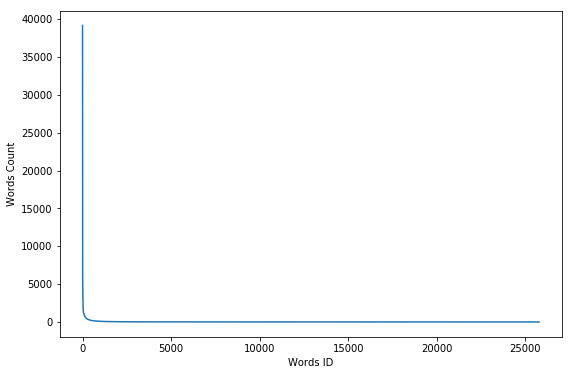

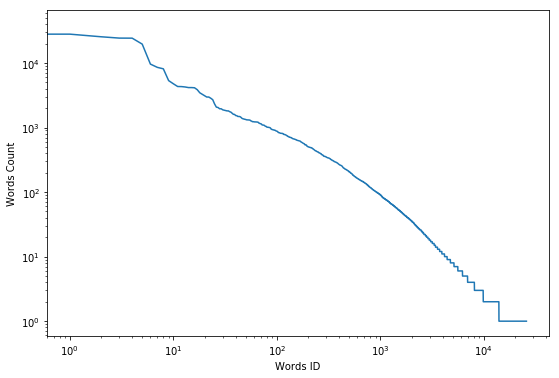

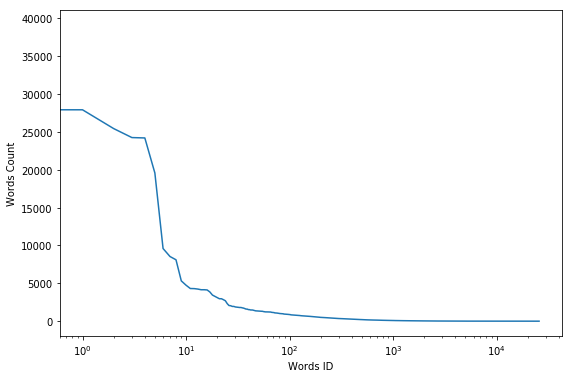

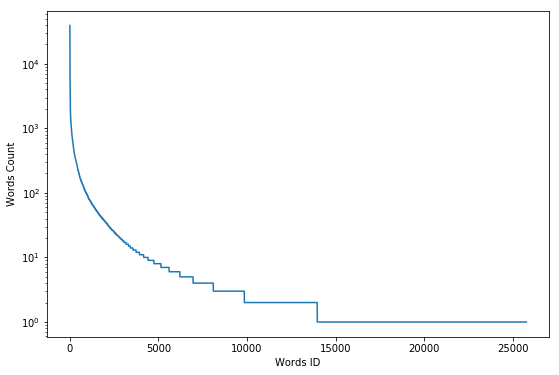

Number of different Words: 25774
Top 10 Words: ['the', 'of', 'and', 'in', 'be', 'to', 'have', '-PRON-', 'a', 'for']
Number of occurrences of top 10 Words: [39174, 27927, 25444, 24258, 24207, 19578, 9598, 8543, 8111, 5326]
Number of Words that only occur once: 11812


In [11]:
tokens_count = {}
for doc in docs_train:
    for token in doc:
        if (token in tokens_count):
            tokens_count[token] += 1
        else:
            tokens_count[token] = 1

tokens_count = {k: v for k, v in sorted(tokens_count.items(), key=lambda item: item[1], reverse=True)}

def plot_tokens(logaxis=None):
    
    plt.figure(figsize=(9, 6))
    plt.plot(list(tokens_count.values()))
    plt.xlabel('Words ID')
    plt.ylabel('Words Count')
    
    if logaxis:
        if logaxis == 'x' or logaxis == 'xy':
            plt.xscale('log')
        if logaxis == 'y' or logaxis == 'xy':
            plt.yscale('log')
    plt.show()
    
plot_tokens()
plot_tokens('xy')
plot_tokens('x')
plot_tokens('y')

num_one = 0
for n in list(tokens_count.values()):
    if n == 1:
        num_one += 1
        
print("Number of different Words:", len(tokens_count))
print("Top 10 Words:", list(tokens_count.keys())[0:10])
print("Number of occurrences of top 10 Words:", list(tokens_count.values())[0:10])
print("Number of Words that only occur once:", num_one)

<h3 style="color:rgb(0,120,170)">Creating a dictionary</h3>
We create a dictionary by removing extremely frequent words and keeping the top <i>MAX_NB_WORDS=20000</i> words

In [12]:
dic = Dictionary(docs_train)
dic.filter_extremes(no_below=1, no_above=0.5, keep_n=MAX_NB_WORDS)
dic.compactify()
print("Total %s unique tokens." % len(dic))

Total 20000 unique tokens.


<h3 style="color:rgb(0,120,170)">Feature vectors of documents</h3>
Using the created dictionary, we first convert text documents to wordIDs and term counts.

In [13]:
docs_train_bow = [dic.doc2bow(_doc) for _doc in docs_train] 
docs_val_bow = [dic.doc2bow(_doc) for _doc in docs_val] 
docs_test_bow = [dic.doc2bow(_doc) for _doc in docs_test] 

# Exercise 3

- Take a look at the bag-of-word dictionary of the training ('docs_train_bow'). How many words does the longest dictionary entry have? How many word does the shortest dictionary entry have?

In [14]:
len_list = [len(doc) for doc in docs_train_bow]

print('Number of Words of longest dictionary:', max(len_list))
print('Number of Words of shortest dictionary:', min(len_list))

Number of Words of longest dictionary: 641
Number of Words of shortest dictionary: 4


<h3 style="color:rgb(0,120,170)">Creating TF-IDF vectors</h3>
To create the TF_IDF vectors, we train the TfidfModel model using the bag-of-word representations of training data

In [15]:
weight_model = TfidfModel(docs_train_bow)

docs_train_tfidf=[]
docs_val_tfidf=[]
docs_test_tfidf=[]

for _bow in docs_train_bow:
    docs_train_tfidf.append(weight_model[_bow])
for _bow in docs_val_bow:
    docs_val_tfidf.append(weight_model[_bow])
for _bow in docs_test_bow:
    docs_test_tfidf.append(weight_model[_bow])

<h3 style="color:rgb(0,120,170)">Dimensionality Reduction</h3>
Before training the models, we want to reduce the dimensionality of the TFIDF vector using the LSA method. <br>
We sparsify the TFIDF vectors, train an SVD model for dimensionality reduction, and reduce the dimension of the vectors.

In [16]:
docs_train_tfidf_sparse = np.zeros((len(docs_train_tfidf), MAX_NB_WORDS))
for doc_i, doc in enumerate(docs_train_tfidf):
    for item in doc:
        docs_train_tfidf_sparse[doc_i][item[0]] = item[1]
        
docs_val_tfidf_sparse = np.zeros((len(docs_val_tfidf), MAX_NB_WORDS))
for doc_i, doc in enumerate(docs_val_tfidf):
    for item in doc:
        docs_val_tfidf_sparse[doc_i][item[0]] = item[1]
        
docs_test_tfidf_sparse = np.zeros((len(docs_test_tfidf), MAX_NB_WORDS))
for doc_i, doc in enumerate(docs_test_tfidf):
    for item in doc:
        docs_test_tfidf_sparse[doc_i][item[0]] = item[1]
        
svd = sklearn.decomposition.TruncatedSVD(n_components=300)
svd.fit(docs_train_tfidf_sparse)

vecs_train = svd.transform(docs_train_tfidf_sparse)
vecs_val = svd.transform(docs_val_tfidf_sparse)
vecs_test = svd.transform(docs_test_tfidf_sparse)

# Exercise 4

- Train different models to predict the labels of the test dataset: NaiveBayes, $k$-nearest neighbors (with $k$=10), and RandomForest (with n_estimators=100).
- Which classifier performs best?
- Plot the accuracy for each of the classifier
- Plot the per-class evaluation of the best classifier

In [17]:
def train(x, y, modelname):
 
    if modelname == 'NaiveBayes':
        clf = GaussianNB()
    elif modelname == 'kNN':
        clf = KNeighborsClassifier(n_neighbors=10)
    elif modelname == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=100, random_state=1)
    
    else:
        print('No or false defintion of model!')
    clf.fit(x, y)
    
    return clf

In [18]:
modelnames = ['NaiveBayes','kNN','RandomForest']
predictions = dict()

for clf in modelnames:
    print(clf)
    model = train(vecs_train, labels_train, clf)
    
    predictions[clf] = model.predict(vecs_test)
    print(predictions[clf])
    
print('Done!')

NaiveBayes
[7 9 4 ... 3 2 9]
kNN
[7 4 4 ... 3 2 3]
RandomForest
[10  9  4 ...  3  2  9]
Done!


In [19]:
results={}

for modelname in predictions:
    results[modelname] = sklearn.metrics.classification_report(labels_test, predictions[modelname], output_dict=True)
    
accuracies = [(_modelname, results[_modelname]['accuracy']) for _modelname in modelnames]

print(accuracies)

[('NaiveBayes', 0.4525), ('kNN', 0.49583333333333335), ('RandomForest', 0.6033333333333334)]


# Answer
The RandomForestClassifier performs the best with an accuracy of 60% on the testset.

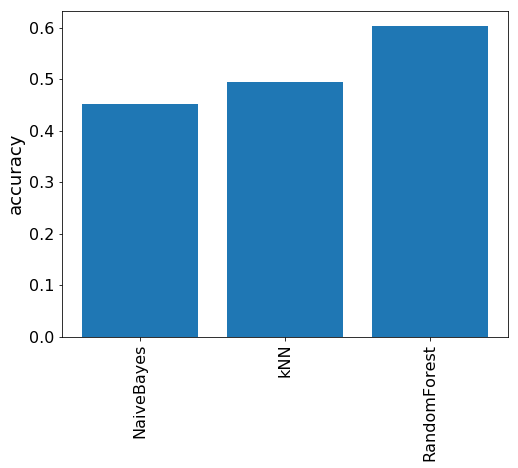

In [20]:
EVAL_MEASURE = 'accuracy'

fig = plt.figure(figsize=(8,6)) 

_data_plot = [results[_modelname][EVAL_MEASURE] for _modelname in modelnames]

plt.bar(modelnames, _data_plot)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()

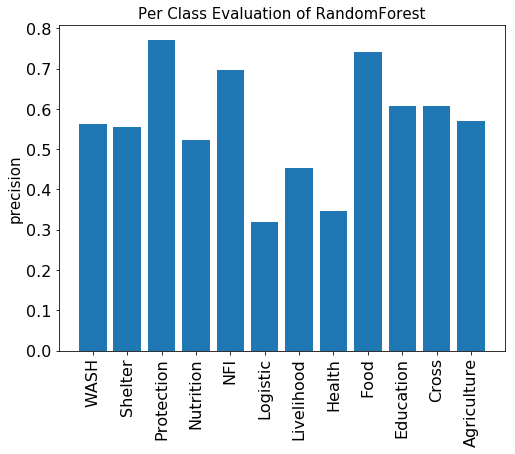

In [21]:
EVAL_MEASURE = 'precision'

MODEL_NAME = 'RandomForest'

fig = plt.figure(figsize=(8,6)) 

_labelids=[x for x in results[MODEL_NAME].keys()][:12]
_labeltexts=[]
_res = []
for _lid in _labelids:
    for _ltext in labelcaptions:
        if str(labelcaptions[_ltext])==_lid:
            _labeltexts.append(_ltext)
            
    _res.append(results[MODEL_NAME][_lid][EVAL_MEASURE])

plt.bar(_labeltexts, _res)
    
plt.title("Per Class Evaluation of %s" % (MODEL_NAME), fontsize=15)
plt.ylabel("%s" % (EVAL_MEASURE), fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.xticks(rotation=90)
plt.show()